In [ ]:
!pip install google-cloud-bigquery==1.25.0 --use-feature=2020-resolver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: google-resumable-media
    Found existing installation: google-resumable-media 2.3.2
    Uninstalling google-resumable-media-2.3.2:
      Successfully uninstalled google-resumable-media-2.3.2
  Attempting uninstall: cachetools
    Found existing installation: cachetools 5.0.0
    Uninstalling cachetools-5.0.0:
      Successfully uninstalled cachetools-5.0.0
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.6.6
    Uninstalling google-auth-2.6.6:
      Successfully uninstalled google-auth-2.6.6
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.7.1
    Uninstalling google-api-core-2.7.1:
      Successfully uninstalled google-api-core-2.7.1
  Attempting 

La commande utilise la fonction magique %%bigquery. Les fonctions magiques dans les notebooks fournissent un alias pour une commande du système. Dans ce cas, %%bigquery exécute la requête dans la cellule dans BigQuery et enregistre le résultat dans un objet DataFrame Pandas appelé df.

In [1]:
%%bigquery df
SELECT
  depdelay as departure_delay,
  COUNT(1) AS num_flights,
  APPROX_QUANTILES(arrdelay, 10) AS arrival_delay_deciles
FROM
  `cloud-training-demos.airline_ontime_data.flights`
WHERE
 depdelay is not null
GROUP BY
  depdelay
HAVING
  num_flights > 100
ORDER BY
  depdelay ASC

In [2]:
df.head()

,departure_delay,num_flights,arrival_delay_deciles
0,-60.0,281,"[-137.0, -65.0, -60.0, -55.0, -36.0, -16.0, -8..."
1,-45.0,262,"[-71.0, -55.0, -50.0, -48.0, -45.0, -43.0, -39..."
2,-44.0,123,"[-62.0, -53.0, -50.0, -48.0, -46.0, -42.0, -40..."
3,-43.0,161,"[-71.0, -55.0, -51.0, -48.0, -45.0, -43.0, -38..."
4,-42.0,193,"[-62.0, -51.0, -48.0, -46.0, -43.0, -41.0, -38..."


Pour obtenir un DataFrame contenant les données dont nous avons besoin, nous devons d'abord superposer le résultat brut de la requête. Saisissez le code suivant dans une nouvelle cellule pour convertir la liste arrival_delay_deciles dans un objet Pandas Series. Le code renomme également les colonnes générées.

In [3]:
import pandas as pd
percentiles = df['arrival_delay_deciles'].apply(pd.Series)
percentiles.rename(columns = lambda x : '{0}%'.format(x*10), inplace=True)
percentiles.head()

,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
0,-137.0,-65.0,-60.0,-55.0,-36.0,-16.0,-8.0,-4.0,1.0,8.0,54.0
1,-71.0,-55.0,-50.0,-48.0,-45.0,-43.0,-39.0,-32.0,-14.0,2.0,45.0
2,-62.0,-53.0,-50.0,-48.0,-46.0,-42.0,-40.0,-33.0,-22.0,-3.0,76.0
3,-71.0,-55.0,-51.0,-48.0,-45.0,-43.0,-38.0,-33.0,-18.0,-5.0,48.0
4,-62.0,-51.0,-48.0,-46.0,-43.0,-41.0,-38.0,-33.0,-20.0,-3.0,32.0


Pour faire le rapprochement entre les retards de départ et les retards d'arrivée, nous devons concaténer notre table percentiles au champ departure_delay dans notre DataFrame d'origine. Exécutez le code suivant dans une nouvelle cellule.

In [4]:
df = pd.concat([df['departure_delay'], percentiles], axis=1)
df.head()

,departure_delay,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
0,-60.0,-137.0,-65.0,-60.0,-55.0,-36.0,-16.0,-8.0,-4.0,1.0,8.0,54.0
1,-45.0,-71.0,-55.0,-50.0,-48.0,-45.0,-43.0,-39.0,-32.0,-14.0,2.0,45.0
2,-44.0,-62.0,-53.0,-50.0,-48.0,-46.0,-42.0,-40.0,-33.0,-22.0,-3.0,76.0
3,-43.0,-71.0,-55.0,-51.0,-48.0,-45.0,-43.0,-38.0,-33.0,-18.0,-5.0,48.0
4,-42.0,-62.0,-51.0,-48.0,-46.0,-43.0,-41.0,-38.0,-33.0,-20.0,-3.0,32.0


Avant de créer un graphique à partir du contenu de notre DataFrame, nous devons retirer les valeurs extrêmes enregistrées dans les champs 0% et 100%. Exécutez le code suivant dans une nouvelle cellule.

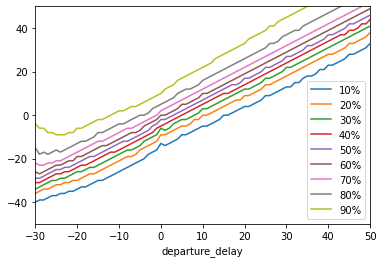

In [5]:
df.drop(labels=['0%', '100%'], axis=1, inplace=True)
df.plot(x='departure_delay', xlim=(-30,50), ylim=(-50,50));